In [1]:
####################################################################################################
# SCRIPT 5 — ISOTONIC CALIBRATED BETTING ENGINE (DAILY DRIVER)
####################################################################################################

In [19]:
####################################################################################################
# 0. SYNC bet_log_live.csv WITH YESTERDAY'S SHORTLIST
#
# Daily responsibilities:
#   - Load rolling bet log (bet_log_live.csv)
#   - Load yesterday's shortlist (bet_shortlist_<yesterday>.csv)
#   - Append those shortlist picks as new planned bets
#   - Clean prob_iso, odds, etc.
#   - Deduplicate by (date, home_team, away_team)
#   - Save updated bet_log_live.csv
#   - Save snapshot bet_log_live_<today>.csv (safety backup)
#
# After this script:
#   bet_log_live.csv = single source of truth for:
#       * past bets incl. stake_eur + won
#       * yesterday's planned bets (stake_eur filled with our standard stake,
#         won still NaN until we settle results tomorrow)
#
# Then other steps will:
#   - fill 'won' based on actual results,
#   - compute bankroll,
#   - compute Kelly sizing for tonight.
####################################################################################################

import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# ======== CONFIG ========

BASE_DIR = r"D:\1. Python\1. NBA Script\2026\LightGBM"

LIVE_LOG_PATH = os.path.join(BASE_DIR, "bet_log_live.csv")

now_dt          = datetime.now()
today_str       = now_dt.strftime("%Y-%m-%d")
yesterday_str   = (now_dt - timedelta(days=1)).strftime("%Y-%m-%d")

SHORTLIST_PATH  = os.path.join(BASE_DIR, f"bet_shortlist_{yesterday_str}.csv")
BACKUP_LOG_PATH = os.path.join(BASE_DIR, f"bet_log_live_{today_str}.csv")

# how much we consider as the default stake (what we actually plan to bet per pick)
DEFAULT_STAKE_EUR = 50.0

TARGET_COLS = [
    "date",
    "home_team",
    "away_team",
    "home_win_rate",
    "prob_iso",
    "odds_1",
    "stake_eur",
    "won"
]

def _clean_numeric(col):
    """
    Helper that converts strings like '2,30' to float 2.30 etc.
    Returns float or NaN.
    """
    return (
        col.astype(str)
           .str.replace(",", ".", regex=False)
           .str.replace("[^0-9.]", "", regex=True)
           .replace("", np.nan)
           .astype(float)
    )

def _coerce_prob_iso(series: pd.Series) -> pd.Series:
    """
    Fix weird formatting like 875 instead of 0.875.
    Rule:
      - if value > 1.0 and <= 1000.0, assume it's missing a decimal and divide by 1000.
      - else keep.
    """
    def fix(v):
        try:
            if pd.isna(v):
                return np.nan
            v = float(v)
        except Exception:
            return np.nan

        if v > 1.0 and v <= 1000.0:
            return v / 1000.0
        return v

    return series.apply(fix)

def _normalize_existing_live(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize what we already have in bet_log_live.csv.
    Keep stake_eur and won from history.
    """
    if df is None or df.empty:
        return pd.DataFrame(columns=TARGET_COLS)

    out = df.copy()

    # normalize column names
    out.columns = (
        out.columns
           .str.strip()
           .str.lower()
           .str.replace(r"\s+", "_", regex=True)
    )

    # legacy aliases
    if "stake" in out.columns and "stake_eur" not in out.columns:
        out = out.rename(columns={"stake": "stake_eur"})
    if "win" in out.columns and "won" not in out.columns:
        out = out.rename(columns={"win": "won"})

    # keep only known cols, fill missing
    keep_cols = [c for c in TARGET_COLS if c in out.columns]
    out = out[keep_cols].copy()
    for col in TARGET_COLS:
        if col not in out.columns:
            out[col] = np.nan

    # type cleanup
    out["date"]          = pd.to_datetime(out["date"], errors="coerce")
    out["home_win_rate"] = _clean_numeric(out["home_win_rate"])
    out["prob_iso"]      = _coerce_prob_iso(_clean_numeric(out["prob_iso"]))
    out["odds_1"]        = _clean_numeric(out["odds_1"])
    out["stake_eur"]     = _clean_numeric(out["stake_eur"])
    out["won"]           = pd.to_numeric(out["won"], errors="coerce")

    # reorder / sort
    out = out[TARGET_COLS]
    out = out.sort_values("date").reset_index(drop=True)

    return out

def _normalize_shortlist(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert bet_shortlist_<yesterday>.csv into rows to append.
    We now ALSO assign stake_eur = DEFAULT_STAKE_EUR (e.g. 50€).
    'won' is still NaN at this step because games just happened.
    """
    if df is None or df.empty:
        return pd.DataFrame(columns=TARGET_COLS)

    raw = df.copy()
    raw.columns = (
        raw.columns
           .str.strip()
           .str.lower()
           .str.replace(r"\s+", "_", regex=True)
    )

    # shortlist usually provides:
    #   date, home_team, away_team,
    #   home_win_rate, prob_iso, odds_1, ev_€_per_100
    # We don't care about EV for logging.
    needed = ["date","home_team","away_team","home_win_rate","prob_iso","odds_1"]
    for col in needed:
        if col not in raw.columns:
            raw[col] = np.nan

    out = pd.DataFrame({
        "date":          pd.to_datetime(raw["date"], errors="coerce"),
        "home_team":     raw["home_team"].astype(str),
        "away_team":     raw["away_team"].astype(str),
        "home_win_rate": _clean_numeric(raw["home_win_rate"]),
        "prob_iso":      _coerce_prob_iso(_clean_numeric(raw["prob_iso"])),
        "odds_1":        _clean_numeric(raw["odds_1"]),
        # 👉 NEW: assign the default stake for these planned bets
        "stake_eur":     float(DEFAULT_STAKE_EUR),
        # not settled yet
        "won":           np.nan
    })

    out = out.sort_values("date").reset_index(drop=True)
    return out

# STEP 1: load current live log
if os.path.exists(LIVE_LOG_PATH):
    live_raw = pd.read_csv(LIVE_LOG_PATH)
else:
    live_raw = pd.DataFrame()
live_norm = _normalize_existing_live(live_raw)

# STEP 2: load yesterday's shortlist and normalize
if os.path.exists(SHORTLIST_PATH):
    shortlist_raw  = pd.read_csv(SHORTLIST_PATH)
    shortlist_norm = _normalize_shortlist(shortlist_raw)
else:
    shortlist_norm = pd.DataFrame(columns=TARGET_COLS)

# STEP 3: append shortlist bets to the live log
combined = pd.concat([live_norm, shortlist_norm], ignore_index=True)

# STEP 4: dedupe by (date, home_team, away_team)
combined.drop_duplicates(
    subset=["date", "home_team", "away_team"],
    keep="last",
    inplace=True
)

# STEP 5: final chronological sort
combined = combined.sort_values("date").reset_index(drop=True)

# STEP 6: save updated master + safety backup
combined.to_csv(LIVE_LOG_PATH, index=False)
combined.to_csv(BACKUP_LOG_PATH, index=False)

# STEP 7: diagnostics (nice to see in console / Actions logs)
print("✅ bet_log_live.csv synchronized with yesterday's shortlist.")
print(f"   LIVE LOG PATH    : {LIVE_LOG_PATH}")
print(f"   DAILY BACKUP PATH: {BACKUP_LOG_PATH}")
print(f"   Yesterday picks source (if existed): {SHORTLIST_PATH}")
print()
print(f"Total rows now: {len(combined)}")
print("Columns      :", list(combined.columns))

tail_n = 20 if len(combined) > 20 else len(combined)
print(f"\nLast {tail_n} rows:")
print(combined.tail(tail_n).to_string(index=False))


✅ bet_log_live.csv synchronized with yesterday's shortlist.
   LIVE LOG PATH    : D:\1. Python\1. NBA Script\2026\LightGBM\bet_log_live.csv
   DAILY BACKUP PATH: D:\1. Python\1. NBA Script\2026\LightGBM\bet_log_live_2025-10-31.csv
   Yesterday picks source (if existed): D:\1. Python\1. NBA Script\2026\LightGBM\bet_shortlist_2025-10-30.csv

Total rows now: 10
Columns      : ['date', 'home_team', 'away_team', 'home_win_rate', 'prob_iso', 'odds_1', 'stake_eur', 'won']

Last 10 rows:
      date home_team away_team  home_win_rate  prob_iso  odds_1  stake_eur  won
2025-10-28       GSW       LAC            1.0  0.666667    2.05       20.0  1.0
2025-10-28       MIA       CHO            1.0  0.750000    1.44       20.0  1.0
2025-10-28       MIL       NYK            1.0  0.710288    2.05       20.0  1.0
2025-10-28       OKC       SAC            1.0  0.857143    1.22       20.0  1.0
2025-10-29       CHI       SAC            1.0  0.875000    1.51       20.0  1.0
2025-10-29       PHO       MEM     

In [20]:
####################################################################################################
# 1. UPDATE 'won' COLUMN IN bet_log_live.csv USING HISTORICAL GAME RESULTS
#
#   - Uses combined_nba_predictions_acc_{today_str}.csv or any full historical file
#   - Compares date, home_team, away_team, result
#   - Marks won=1 if home_team == result
#   - Marks won=0 if away_team == result
####################################################################################################

import pandas as pd
import os
import glob

BASE_DIR = r"D:\1. Python\1. NBA Script\2026\LightGBM"
LIVE_LOG_PATH = os.path.join(BASE_DIR, "bet_log_live.csv")

# Find the most recent combined prediction file with results
pattern = os.path.join(BASE_DIR, "combined_nba_predictions_acc_*.csv")
files = sorted(glob.glob(pattern))

if not files:
    raise FileNotFoundError("No combined_nba_predictions_acc_*.csv files found.")
latest_results_path = files[-1]

print(f"Using game results from: {os.path.basename(latest_results_path)}")

# Load both files
df_log = pd.read_csv(LIVE_LOG_PATH)
df_res = pd.read_csv(latest_results_path, encoding="utf-7")

# Normalize columns
for df in [df_log, df_res]:
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(r"\s+", "_", regex=True)
    )

# Ensure date alignment
df_log["date"] = pd.to_datetime(df_log["date"], errors="coerce").dt.date
df_res["date"] = pd.to_datetime(df_res["date"], errors="coerce").dt.date

# Keep relevant columns from results
df_res = df_res[["date", "home_team", "away_team", "result"]].dropna()

# Merge logs with results
merged = pd.merge(
    df_log,
    df_res,
    how="left",
    on=["date", "home_team", "away_team"]
)

# Update 'won' column
merged["won"] = merged.apply(
    lambda r: 1 if r["result"] == r["home_team"] else (0 if r["result"] == r["away_team"] else np.nan),
    axis=1
)

# Drop the extra 'result' column
merged = merged.drop(columns=["result"])

# Save back to live log
merged.to_csv(LIVE_LOG_PATH, index=False)

print(f"✅ Updated bet_log_live.csv with actual game outcomes.")
print(merged.tail(10).to_string(index=False))


Using game results from: combined_nba_predictions_acc_2025-10-31.csv
✅ Updated bet_log_live.csv with actual game outcomes.
      date home_team away_team  home_win_rate  prob_iso  odds_1  stake_eur  won
2025-10-28       GSW       LAC            1.0  0.666667    2.05       20.0    1
2025-10-28       MIA       CHO            1.0  0.750000    1.44       20.0    1
2025-10-28       MIL       NYK            1.0  0.710288    2.05       20.0    1
2025-10-28       OKC       SAC            1.0  0.857143    1.22       20.0    1
2025-10-29       CHI       SAC            1.0  0.875000    1.51       20.0    1
2025-10-29       PHO       MEM            1.0  0.636364    2.02       20.0    0
2025-10-29       UTA       POR            1.0  0.714286    2.24       20.0    0
2025-10-30       CHO       ORL            1.0  0.900000    2.15       50.0    0
2025-10-30       MIL       GSW            1.0  0.857000    2.30       50.0    1
2025-10-30       SAS       MIA            1.0  0.900000    1.42       50.0   


📊 BETTING PERFORMANCE SUMMARY
──────────────────────────────
Total bets made     : 10
Wins / Losses       : 7 / 3
Win rate (%)        : 70.00
Total staked (€)    : 290.00
Total profit (€)    : 61.40
ROI (%)             : 21.17
Final bankroll (€)  : 1061.40


C:\Users\alexx\AppData\Local\Temp\ipykernel_27056\1734722126.py:64: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\1. Python\Python Installation x64\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


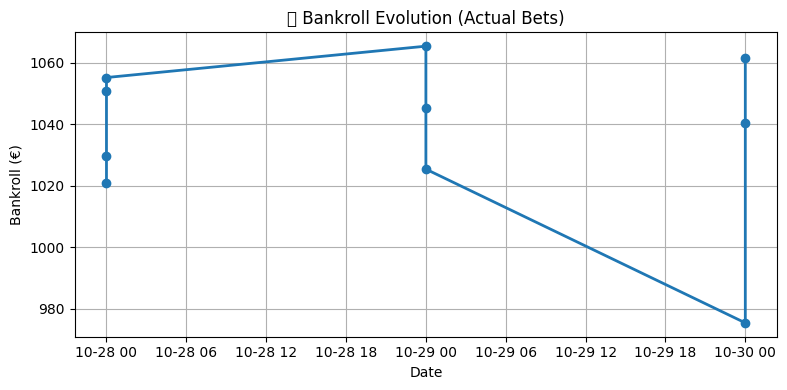


💾 Detailed results saved to: D:\1. Python\1. NBA Script\2026\LightGBM\betting_summary_2025-10-31.xlsx


In [21]:
####################################################################################################
# 2. BETTING STATISTICS AND PERFORMANCE SUMMARY
#
# Reads bet_log_live.csv, computes profit, ROI, win rate, and cumulative curve.
####################################################################################################

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

BASE_DIR = r"D:\1. Python\1. NBA Script\2026\LightGBM"
LIVE_LOG_PATH = os.path.join(BASE_DIR, "bet_log_live.csv")

# --- Load the current log ---
df = pd.read_csv(LIVE_LOG_PATH)

# Type cleanup
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["odds_1"] = pd.to_numeric(df["odds_1"], errors="coerce")
df["stake_eur"] = pd.to_numeric(df["stake_eur"], errors="coerce")
df["won"] = pd.to_numeric(df["won"], errors="coerce")

# --- Calculate profit per bet ---
df["profit_eur"] = np.where(
    df["won"] == 1,
    df["stake_eur"] * (df["odds_1"] - 1),
    -df["stake_eur"]
)

# --- Cumulative bankroll simulation ---
starting_bankroll = 1000.0
df = df.sort_values("date").reset_index(drop=True)
df["cum_profit"] = df["profit_eur"].cumsum()
df["bankroll"] = starting_bankroll + df["cum_profit"]

# --- Summary stats ---
total_bets = len(df)
wins = df["won"].sum()
losses = total_bets - wins
win_rate = (wins / total_bets * 100) if total_bets else 0
total_staked = df["stake_eur"].sum()
total_profit = df["profit_eur"].sum()
roi = (total_profit / total_staked * 100) if total_staked else 0

# --- Display summary ---
print("\n📊 BETTING PERFORMANCE SUMMARY")
print("──────────────────────────────")
print(f"Total bets made     : {total_bets}")
print(f"Wins / Losses       : {int(wins)} / {int(losses)}")
print(f"Win rate (%)        : {win_rate:.2f}")
print(f"Total staked (€)    : {total_staked:.2f}")
print(f"Total profit (€)    : {total_profit:.2f}")
print(f"ROI (%)             : {roi:.2f}")
print(f"Final bankroll (€)  : {df['bankroll'].iloc[-1]:.2f}")

# --- Plot cumulative bankroll evolution ---
plt.figure(figsize=(8,4))
plt.plot(df["date"], df["bankroll"], marker="o", linewidth=2)
plt.title("🏀 Bankroll Evolution (Actual Bets)")
plt.xlabel("Date")
plt.ylabel("Bankroll (€)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Optional: Save stats summary ---
summary_path = os.path.join(BASE_DIR, f"betting_summary_{pd.Timestamp.today().date()}.xlsx")
df.to_excel(summary_path, index=False)
print(f"\n💾 Detailed results saved to: {summary_path}")


In [22]:
####################################################################################################
# 4. GRID SEARCH FOR BEST PARAM COMBO (HISTORICAL ONLY)
####################################################################################################

import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.isotonic import IsotonicRegression

# ========= PATHS / DATES =========
BASE_DIR = r"D:\1. Python\1. NBA Script\2026\LightGBM"

today = datetime.now()
today_date = today.date()
tomorrow_date = (today + timedelta(days=1)).date()

today_str = today.strftime("%Y-%m-%d")
yesterday_str = (today - timedelta(days=1)).strftime("%Y-%m-%d")

COMBINED_FILE = os.path.join(BASE_DIR, f"combined_nba_predictions_acc_{today_str}.csv")
HWR_FILE      = os.path.join(BASE_DIR, f"home_win_rates_sorted_{today_str}.csv")
TODAY_PRED    = os.path.join(BASE_DIR, f"nba_games_predict_{today_str}.csv")

print("Using data for:", today_str)
print("Combined file:", COMBINED_FILE)
print("Home win rates file:", HWR_FILE)
print("Today's prediction file:", TODAY_PRED)

# ========= BET CONFIG / SEARCH SPACE =========
FLAT_STAKE      = 100.0   # stake per bet in backtest
LOOKAHEAD_HRS   = 36      # still used later for shortlist window, but we'll also do day-based logic
ODDS_MIN_GRID   = np.arange(1.1, 3.1, 0.1)
ODDS_MAX_GRID   = np.arange(1.2, 3.6, 0.1)
PROB_MIN_GRID   = np.arange(0.40, 0.90, 0.05)
HOMEWR_MIN_GRID = np.arange(0.50, 0.90, 0.05)

# ========= helper: numeric cleaner =========
def to_float_series(s):
    return (
        s.astype(str)
         .str.replace(",", ".", regex=False)
         .str.replace("[^0-9.]", "", regex=True)
         .replace("", np.nan)
         .astype(float)
    )

# ========= 1A. LOAD HISTORICAL/COMBINED FILE =========
if not os.path.exists(COMBINED_FILE):
    raise FileNotFoundError(f"Missing combined file: {COMBINED_FILE}")

df_all = pd.read_csv(COMBINED_FILE, encoding="utf-7", decimal=",")
df_all.columns = (
    df_all.columns
         .str.strip()
         .str.lower()
         .str.replace(r"\s+","_", regex=True)
)

# coerce types
df_all["date"] = pd.to_datetime(df_all["date"], errors="coerce")
if "odds_1" in df_all.columns:
    df_all["odds_1"] = to_float_series(df_all["odds_1"])
if "odds_2" in df_all.columns:
    df_all["odds_2"] = to_float_series(df_all["odds_2"])
df_all["home_team_prob"] = to_float_series(df_all["home_team_prob"])

# result-based win flag
df_all["win"] = (df_all["result"] == df_all["home_team"]).astype(int)

# mark rows we consider already decided
df_all["is_played"] = (
    df_all["result"].notna()
    & (df_all["result"].astype(str) != "0")
)

# make sure away_team exists (combined sometimes might)
if "away_team" not in df_all.columns:
    df_all["away_team"] = np.nan

# ========= 1B. LOAD TONIGHT'S PREDICTIONS AND MERGE =========
new_rows = pd.DataFrame()
if os.path.exists(TODAY_PRED):
    tmp = pd.read_csv(
        TODAY_PRED,
        encoding="utf-7",
        sep=",",
        quotechar='"',
        decimal=","
    )

    expected = {"home_team","away_team","home_team_prob"}
    if not expected.issubset({c.lower().strip() for c in tmp.columns}):
        # fallback schema
        tmp = pd.read_csv(
            TODAY_PRED,
            encoding="utf-7",
            sep=",",
            quotechar='"',
            decimal=",",
            header=None,
            names=["home_team","away_team","home_team_prob","odds_1","odds_2","result","date"]
        )

    # normalize
    tmp.columns = (
        tmp.columns
           .str.strip()
           .str.lower()
           .str.replace(r"\s+","_", regex=True)
    )

    # numeric cleanup
    tmp["home_team_prob"] = to_float_series(tmp.get("home_team_prob", np.nan))
    tmp["odds_1"]         = to_float_series(tmp.get("odds_1", np.nan))
    tmp["odds_2"]         = to_float_series(tmp.get("odds_2", np.nan))

    # date cleanup
    tmp["date"] = pd.to_datetime(tmp.get("date", pd.NaT), errors="coerce")

    # if still NaT, assume "today"
    tmp.loc[tmp["date"].isna(), "date"] = pd.Timestamp(today_date)

    # mark state
    tmp["win"]       = np.nan
    tmp["is_played"] = False

    # ensure these cols exist for key-matching
    if "away_team" not in df_all.columns:
        df_all["away_team"] = np.nan

    # anti-duplicate by (date, home_team, away_team)
    key_cols = ["date","home_team","away_team"]
    merged_keys = df_all[key_cols].drop_duplicates()

    tmp_merge = tmp.merge(
        merged_keys,
        on=key_cols,
        how="left",
        indicator=True
    )
    new_rows = tmp_merge[tmp_merge["_merge"] == "left_only"].drop(columns=["_merge"])

    # align columns before concat
    needed_cols = set(df_all.columns) | set(new_rows.columns)
    for col in needed_cols:
        if col not in df_all.columns:
            df_all[col] = np.nan
        if col not in new_rows.columns:
            new_rows[col] = np.nan

    # force upcoming rows to `is_played = False`
    new_rows["is_played"] = False

    # append to df_all
    if not new_rows.empty:
        df_all = pd.concat(
            [df_all, new_rows[df_all.columns]],
            ignore_index=True
        )

# ========= 1C. UPCOMING COUNT (DAY-BASED, NOT TIME-OF-DAY) =========
df_all["game_day"] = df_all["date"].dt.date

upcoming_mask = (
    (~df_all["is_played"])
    &
    (
        (df_all["game_day"] == today_date) |
        (df_all["game_day"] == tomorrow_date)
    )
)

n_upcoming = int(upcoming_mask.sum())

print("Rows total      :", len(df_all))
print("Completed games :", int(df_all["is_played"].sum()))
print("Upcoming games  :", n_upcoming)

# optional sanity print of upcoming slate
if n_upcoming > 0:
    preview_cols = [
        "date","home_team","away_team",
        "home_team_prob","odds_1","odds_2","is_played"
    ]
    print("\nUpcoming (today/tomorrow):")
    print(
        df_all.loc[upcoming_mask, preview_cols]
              .sort_values("date")
              .round({"home_team_prob":3,"odds_1":3,"odds_2":3})
              .to_string(index=False)
    )
else:
    print("\nNo upcoming (today/tomorrow) games detected after merge.")


Using data for: 2025-10-31
Combined file: D:\1. Python\1. NBA Script\2026\LightGBM\combined_nba_predictions_acc_2025-10-31.csv
Home win rates file: D:\1. Python\1. NBA Script\2026\LightGBM\home_win_rates_sorted_2025-10-31.csv
Today's prediction file: D:\1. Python\1. NBA Script\2026\LightGBM\nba_games_predict_2025-10-31.csv
Rows total      : 80
Completed games : 72
Upcoming games  : 8

Upcoming (today/tomorrow):
      date home_team away_team  home_team_prob  odds_1  odds_2  is_played
2025-10-31       CHI       NYK           0.697    2.60    1.52      False
2025-10-31       CLE       TOR           0.669    1.35    3.30      False
2025-10-31       IND       ATL           0.588    2.24    1.68      False
2025-10-31       LAC       NOP           0.640    1.19    5.00      False
2025-10-31       MEM       LAL           0.551    1.80    2.05      False
2025-10-31       PHI       BOS           0.501    1.70    2.20      False
2025-10-31       PHO       UTA           0.555    1.65    2.30     

In [23]:
####################################################################################################
# 5. ISOTONIC CALIBRATION
#    Fit on completed games only, then apply to all rows.
####################################################################################################

hist_mask = df_all["is_played"] & df_all["home_team_prob"].notna()
hist_calib = df_all.loc[hist_mask, ["home_team_prob", "win"]].copy()

if hist_calib.empty:
    print("Not enough completed games to calibrate, using raw model probs.")
    df_all["prob_iso"] = df_all["home_team_prob"]
    iso = None
else:
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(
        hist_calib["home_team_prob"].values,
        hist_calib["win"].values
    )
    df_all["prob_iso"] = iso.transform(df_all["home_team_prob"].values)

# quick diagnostic: calibration reliability buckets
if hist_calib.shape[0] >= 10:
    calib_bins = (
        df_all.loc[hist_mask]
              .assign(prob_bin=pd.cut(
                  df_all.loc[hist_mask, "prob_iso"],
                  bins=[0,0.4,0.5,0.6,0.7,0.8,1.0]
              ))
              .groupby("prob_bin", observed=True)
              .agg(
                  avg_calib_prob=("prob_iso","mean"),
                  actual_home_win_rate=("win","mean"),
                  n_games=("win","size")
              )
              .round(3)
    )
    print("\nCalibration bins:")
    print(calib_bins)
else:
    print("\nSkipping calibration bins (not enough historical samples).")



Calibration bins:
            avg_calib_prob  actual_home_win_rate  n_games
prob_bin                                                 
(0.4, 0.5]           0.458                 0.458       24
(0.5, 0.6]           0.562                 0.562       16
(0.6, 0.7]           0.667                 0.667        6
(0.8, 1.0]           0.864                 0.864       22


In [24]:
####################################################################################################
# 6. Calculate Home Win Rate
####################################################################################################

# Set directory path
read_file_path = os.path.join(BASE_DIR, f'combined_nba_predictions_acc_{today_str}.csv')

# Load the dataset
df = pd.read_csv(read_file_path,encoding="utf-7")

# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Function to get last 20 games and home win rates for all teams
def get_last_20_games_all_teams(df):
    team_results = {}

    for team in df['home_team'].unique():
        # Get last 20 games for the team (home or away)
        team_games = df[(df['home_team'] == team) | (df['away_team'] == team)]
        team_games = team_games.sort_values(by='date', ascending=False).head(20)

        # Filter only home games from those 20
        home_games = team_games[team_games['home_team'] == team]

        # Calculate home win rate
        total_home_games = len(home_games)
        home_wins = len(home_games[home_games['result'] == team])
        home_win_rate = round(home_wins / total_home_games, 2) if total_home_games > 0 else 0

        # Store results in dictionary
        team_results[team] = {
            "Total Last 20 Games": len(team_games),
            "Total Home Games": total_home_games,
            "Home Wins": home_wins,
            "Home Win Rate": home_win_rate
        }

    # Convert to DataFrame
    home_win_rates_df = pd.DataFrame.from_dict(team_results, orient='index')

    # Sort by Home Win Rate in descending order
    home_win_rates_df.sort_values(by="Home Win Rate", ascending=False, inplace=True)

    return home_win_rates_df

# Get last 20 games and home win rates for all teams
home_win_rates_all_teams_sorted = get_last_20_games_all_teams(df)

# Display sorted results
print("\n🏀 Home Win Rates (Sorted) for All Teams:")
print(home_win_rates_all_teams_sorted)

# Save to CSV (Optional)
output_file = os.path.join(BASE_DIR, f'home_win_rates_sorted_{today_str}.csv')
home_win_rates_all_teams_sorted.to_csv(output_file, index=True)
print(f"\n📁 Sorted home win rates saved to: {output_file}")



🏀 Home Win Rates (Sorted) for All Teams:
     Total Last 20 Games  Total Home Games  Home Wins  Home Win Rate
SAS                    5                 3          3           1.00
OKC                    6                 3          3           1.00
MIL                    5                 3          3           1.00
CHI                    4                 3          3           1.00
DEN                    4                 2          2           1.00
MIA                    5                 2          2           1.00
CLE                    5                 1          1           1.00
PHI                    4                 2          2           1.00
LAC                    4                 2          2           1.00
NYK                    4                 2          2           1.00
GSW                    6                 3          3           1.00
MEM                    5                 3          2           0.67
UTA                    4                 3          2        

In [25]:
####################################################################################################
# 7. HOME STRENGTH LOOKUP
#    Attach rolling home win rate for each home_team.
####################################################################################################

if not os.path.exists(HWR_FILE):
    raise FileNotFoundError(f"Missing home win rate file: {HWR_FILE}")

hwr = pd.read_csv(HWR_FILE, index_col=0)
hwr.columns = [c.strip() for c in hwr.columns]  # should include "Home Win Rate"

df_all["home_win_rate"] = df_all["home_team"].map(hwr["Home Win Rate"])

print("Example home_win_rate mapping:")
print(df_all[["home_team","home_win_rate"]].head())


Example home_win_rate mapping:
  home_team  home_win_rate
0       SAS            1.0
1       OKC            1.0
2       MIL            1.0
3       CHO            0.5
4       BRK            0.0


In [26]:
####################################################################################################
# 8. Caclulation of results based on BEST PARAM COMBO (HISTORICAL ONLY)
#
# We'll search:
#   - minimum home_win_rate
#   - odds_1 in [odds_min, odds_max]
#   - minimum calibrated prob_iso
#
# Scoring:
#   stake = FLAT_STAKE each bet
#   pnl = +stake*(odds_1-1) if home wins, else -stake
#
# We pick the combo with the highest total profit.
####################################################################################################

hist_df = df_all[df_all["is_played"]].copy()

best_profit = float("-inf")
best_params = None
best_subset = None

for hw_cut in HOMEWR_MIN_GRID:
    strong_homes = hwr[hwr["Home Win Rate"] >= hw_cut].index.tolist()

    for o_min in ODDS_MIN_GRID:
        for o_max in ODDS_MAX_GRID:
            if o_max <= o_min:
                continue

            for p_min in PROB_MIN_GRID:

                mask_subset = (
                    (hist_df["home_team"].isin(strong_homes)) &
                    (hist_df["odds_1"]      >= o_min) &
                    (hist_df["odds_1"]      <= o_max) &
                    (hist_df["prob_iso"]    >= p_min)
                )
                subset = hist_df.loc[mask_subset].copy()
                if subset.empty:
                    continue

                # flat-stake pnl
                subset["pnl"] = np.where(
                    subset["win"] == 1,
                    FLAT_STAKE * (subset["odds_1"] - 1.0),
                    -FLAT_STAKE
                )

                total_profit = subset["pnl"].sum()
                n_trades     = len(subset)

                if total_profit > best_profit and n_trades > 0:
                    best_profit = total_profit
                    best_params = {
                        "home_win_rate_threshold": round(hw_cut, 2),
                        "odds_min": round(o_min, 2),
                        "odds_max": round(o_max, 2),
                        "prob_threshold": round(p_min, 2),
                        "n_trades": n_trades,
                        "win_rate_%": round(subset["win"].mean() * 100, 2),
                    }
                    best_subset = subset.copy()

if best_params is None:
    print("No profitable parameter combo found. Check data / ranges.")
else:
    total_stake = best_params["n_trades"] * FLAT_STAKE
    roi_pct = (best_profit / total_stake * 100.0) if total_stake else 0.0

    print("\n=== BEST PARAMS (ISOTONIC, HISTORICAL) ===")
    print(f"home_win_rate_threshold : {best_params['home_win_rate_threshold']}")
    print(f"odds_min                : {best_params['odds_min']}")
    print(f"odds_max                : {best_params['odds_max']}")
    print(f"prob_threshold (iso)    : {best_params['prob_threshold']}")
    #print(f"n_trades                : {best_params['n_trades']}")
    #print(f"win_rate_%              : {best_params['win_rate_%']}")
    #print(f"total_profit €          : {best_profit:.2f}")
    #print(f"ROI %                   : {roi_pct:.2f}%")

    # print("\nSample of historical bets that match best params:")
    # cols_preview = [
    #     "date","home_team","away_team",
    #     "home_win_rate","prob_iso","odds_1","result","win","pnl"
    # ]
    # print(
    #     best_subset[cols_preview]
    #     .sort_values("date")
    #     .head(15)
    #     .round(3)
    #     .to_string(index=False)
    # )


# ####################################################################################################
# # 6. SEASON PERFORMANCE DASHBOARD (ISOTONIC STRATEGY)
# #    Visualize cumulative profit, rolling win rate, and calibration reliability.
# #    NEW: Save historical qualified bets to CSV.
# ####################################################################################################

# import matplotlib.pyplot as plt

# # --- Filter for historical (played) games ---
# hist = df_all[df_all["is_played"]].copy()

# # Only consider those that would have qualified under tuned params
# mask_hist = (
#     (hist["home_win_rate"] >= best_params["home_win_rate_threshold"]) &
#     (hist["odds_1"]      >= best_params["odds_min"]) &
#     (hist["odds_1"]      <= best_params["odds_max"]) &
#     (hist["prob_iso"]    >= best_params["prob_threshold"])
# )
# hist_sel = hist.loc[mask_hist].copy()

# if hist_sel.empty:
#     print("No historical bets matching current isotonic strategy — not enough data for chart.")
# else:
#     # Calculate flat-stake PnL per game
#     hist_sel["pnl"] = np.where(
#         hist_sel["win"] == 1,
#         FLAT_STAKE * (hist_sel["odds_1"] - 1.0),
#         -FLAT_STAKE
#     )

#     # Explicit: which side are we 'betting'
#     hist_sel["bet_side"] = hist_sel["home_team"]

#     # Sort chronologically
#     hist_sel = hist_sel.sort_values("date").reset_index(drop=True)

#     # Cumulative profit
#     hist_sel["cum_profit"] = hist_sel["pnl"].cumsum()

#     # Rolling win rate (last 10 bets)
#     hist_sel["rolling_win_rate"] = hist_sel["win"].rolling(10, min_periods=3).mean() * 100

#     # Calibration reliability: predicted vs actual
#     calib_plot = (
#         hist_sel
#         .assign(prob_bin=pd.cut(hist_sel["prob_iso"], bins=np.arange(0,1.05,0.1)))
#         .groupby("prob_bin", observed=True)
#         .agg(predicted_prob=("prob_iso", "mean"),
#              actual_win=("win", "mean"))
#         .dropna()
#     )

#     # ============================
#     # NEW: SAVE HISTORICAL SIGNAL
#     # ============================
#     HIST_EXPORT_PATH = os.path.join(BASE_DIR, "bet_history_strategy.csv")

#     hist_export_cols = [
#         "date",
#         "home_team",
#         "away_team",
#         "bet_side",
#         "home_win_rate",
#         "prob_iso",
#         "odds_1",
#         "win",          # 1 if home actually won
#         "pnl",          # profit (FLAT_STAKE basis) on that game
#         "cum_profit"    # running bankroll using FLAT_STAKE bets
#     ]

#     # round some numeric columns for readability in the CSV
#     hist_to_save = (
#         hist_sel[hist_export_cols]
#         .copy()
#         .sort_values("date")
#         .round({
#             "home_win_rate":3,
#             "prob_iso":3,
#             "odds_1":3,
#             "pnl":2,
#             "cum_profit":2
#         })
#     )

#     hist_to_save.to_csv(HIST_EXPORT_PATH, index=False)
#     print(f"💾 Saved historical qualified bets to {HIST_EXPORT_PATH}")
#     print(f"   ({len(hist_to_save)} rows total so far)")

#     # --- Plot 1: Cumulative profit ---
#     plt.figure(figsize=(8,4))
#     plt.plot(hist_sel["date"], hist_sel["cum_profit"], marker="o")
#     plt.title("Cumulative Profit (Isotonic Strategy)")
#     plt.xlabel("Date")
#     plt.ylabel("Total Profit (€)")
#     plt.grid(True)
#     plt.show()

#     # --- Plot 2: Rolling win rate ---
#     plt.figure(figsize=(8,4))
#     plt.plot(hist_sel["date"], hist_sel["rolling_win_rate"], marker="o")
#     plt.title("Rolling 10-Game Win Rate (%)")
#     plt.axhline(50, color="gray", linestyle="--", label="Break-even 50%")
#     plt.ylabel("Win Rate (%)")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # --- Plot 3: Calibration curve ---
#     plt.figure(figsize=(5,5))
#     plt.plot(calib_plot["predicted_prob"], calib_plot["actual_win"], marker="o")
#     plt.plot([0,1],[0,1],"--",color="gray")
#     plt.title("Calibration Curve (Isotonic Model)")
#     plt.xlabel("Predicted Probability")
#     plt.ylabel("Actual Win Rate")
#     plt.grid(True)
#     plt.show()

#     print(f"\nSeason summary (so far):")
#     print(f"  Bets placed        : {len(hist_sel)}")
#     print(f"  Win rate           : {hist_sel['win'].mean() * 100:.2f}%")
#     print(f"  Total profit (€)   : {hist_sel['cum_profit'].iloc[-1]:.2f}")
#     print(f"  Avg EV per bet (€) : {hist_sel['pnl'].mean():.2f}")



=== BEST PARAMS (ISOTONIC, HISTORICAL) ===
home_win_rate_threshold : 0.55
odds_min                : 1.1
odds_max                : 2.9
prob_threshold (iso)    : 0.4


In [28]:
####################################################################################################
# 9. APPLY BEST PARAMS TO UPCOMING GAMES (NEXT 36H) + KELLY SIZING + REASONS
####################################################################################################

CARD_OUT_PATH    = os.path.join(BASE_DIR, f"bet_shortlist_{today_str}.csv")
BET_LOG_MASTER   = os.path.join(BASE_DIR, "bet_log_live.csv")

INITIAL_BANKROLL        = 1000.0   # starting bankroll if no history yet
KELLY_FRACTION          = 0.5      # half Kelly for safety
MAX_RISK_PCT_PER_BET    = 0.05     # never risk >20% of bankroll on a single bet
MIN_STAKE_ABS           = 10.0     # don't place bets smaller than 10 €

def get_current_bankroll():
    """
    Reads last known bankroll from bet_log_live.csv.
    Falls back to INITIAL_BANKROLL if no settled bankroll found.
    """
    if os.path.exists(BET_LOG_MASTER):
        _log = pd.read_csv(BET_LOG_MASTER)
        if "bankroll_after" in _log.columns and _log["bankroll_after"].notna().any():
            return float(_log["bankroll_after"].dropna().iloc[-1])
    return INITIAL_BANKROLL

def kelly_fraction_row(p, odds_decimal):
    """
    Kelly fraction for a single-outcome bet (home team ML).
    p = calibrated win probability (prob_iso)
    odds_decimal = decimal odds on the home team (odds_1)
    Formula: f* = (p * odds - 1) / (odds - 1)
    Can be negative (=> don't bet).
    """
    if pd.isna(p) or pd.isna(odds_decimal):
        return np.nan
    b = odds_decimal - 1.0
    if b <= 0:
        return np.nan
    numer = p * odds_decimal - 1.0
    denom = b
    return numer / denom


def load_today_predictions_safe(path_csv, iso_model, hwr_df):
    """
    Fallback loader if df_all has no future rows.
    Returns columns:
      date, home_team, away_team, home_team_prob, prob_iso,
      home_win_rate, odds_1, odds_2, is_played
    or empty DF.
    """
    if not os.path.exists(path_csv):
        return pd.DataFrame()

    # First try read with header
    tmp = pd.read_csv(
        path_csv,
        encoding="utf-7",
        sep=",",
        quotechar='"',
        decimal=","
    )

    # Check if header looked good; if not, force schema
    expected = {"home_team","away_team","home_team_prob"}
    if not expected.issubset({c.lower().strip() for c in tmp.columns}):
        tmp = pd.read_csv(
            path_csv,
            encoding="utf-7",
            sep=",",
            quotechar='"',
            decimal=",",
            header=None,
            names=["home_team","away_team","home_team_prob","odds_1","odds_2","result","date"]
        )

    # normalize cols
    tmp.columns = (
        tmp.columns
           .str.strip()
           .str.lower()
           .str.replace(r"\s+","_", regex=True)
    )

    # numeric cleanup
    def _to_float_series(s):
        return (
            s.astype(str)
             .str.replace(",", ".", regex=False)
             .str.replace("[^0-9.]", "", regex=True)
             .replace("", np.nan)
             .astype(float)
        )

    if "home_team_prob" in tmp.columns:
        tmp["home_team_prob"] = _to_float_series(tmp["home_team_prob"])
    else:
        tmp["home_team_prob"] = np.nan

    if "odds_1" in tmp.columns:
        tmp["odds_1"] = _to_float_series(tmp["odds_1"])
    else:
        tmp["odds_1"] = np.nan

    if "odds_2" in tmp.columns:
        tmp["odds_2"] = _to_float_series(tmp["odds_2"])
    else:
        tmp["odds_2"] = np.nan

    if "date" in tmp.columns:
        tmp["date"] = pd.to_datetime(tmp["date"], errors="coerce")
    else:
        tmp["date"] = pd.NaT

    # attach home win rate
    tmp["home_win_rate"] = tmp["home_team"].map(hwr_df["Home Win Rate"])

    # calibrated prob
    if iso_model is not None:
        tmp["prob_iso"] = iso_model.transform(tmp["home_team_prob"].values)
    else:
        tmp["prob_iso"] = tmp["home_team_prob"]

    tmp["is_played"] = False

    keep_cols = [
        "date","home_team","away_team",
        "home_team_prob","prob_iso",
        "home_win_rate","odds_1","odds_2",
        "is_played"
    ]
    for k in keep_cols:
        if k not in tmp.columns:
            tmp[k] = np.nan

    return tmp[keep_cols].copy()


# ---- main shortlist logic ----

card = pd.DataFrame()  # define here so it's visible after the if-blocks

if best_params is None:
    print("\n(No best params found; skipping shortlist.)")

else:
    now_norm = pd.Timestamp.now().normalize()
    cutoff   = now_norm + pd.Timedelta(hours=LOOKAHEAD_HRS)

    # take future games from df_all
    upcoming = df_all[
        (~df_all["is_played"]) &
        (df_all["date"] >= now_norm) &
        (df_all["date"] <= cutoff)
    ].copy()

    # if we don't have any future rows in df_all (common early season),
    # fall back to today's prediction csv
    if upcoming.empty:
        hwr_df_local = pd.read_csv(HWR_FILE, index_col=0)
        hwr_df_local.columns = [c.strip() for c in hwr_df_local.columns]
        iso_model = iso if "iso" in globals() else None
        upcoming = load_today_predictions_safe(TODAY_PRED, iso_model, hwr_df_local)

    # still nothing? then no slate
    if upcoming.empty:
        print("\n=== TONIGHT'S SHORTLIST (ISOTONIC + KELLY) ===")
        print("No upcoming games found in df_all or today's prediction file.")

    else:
        # shortlist filter (based on best_params found in grid search)
        mask_card = (
            (upcoming["home_win_rate"] >= best_params["home_win_rate_threshold"]) &
            (upcoming["odds_1"]      >= best_params["odds_min"]) &
            (upcoming["odds_1"]      <= best_params["odds_max"]) &
            (upcoming["prob_iso"]    >= best_params["prob_threshold"])
        )
        card = upcoming.loc[mask_card].copy()

        # Expected value per 100€ flat stake (still useful for ranking / sanity)
        card["EV_€_per_100"] = (
            card["prob_iso"] * (card["odds_1"] - 1.0)
            - (1.0 - card["prob_iso"])
        ) * FLAT_STAKE

        # --- Kelly bankroll sizing ---
        current_bankroll = get_current_bankroll()
        print(f"\n💰 Current bankroll for sizing bets: {current_bankroll:.2f} €")

        # raw Kelly fraction
        card["kelly_full"] = card.apply(
            lambda r: kelly_fraction_row(r["prob_iso"], r["odds_1"]),
            axis=1
        )

        # apply fractional Kelly and caps
        card["kelly_fraction_used"] = (card["kelly_full"] * KELLY_FRACTION).clip(lower=0)
        card["kelly_fraction_used"] = card["kelly_fraction_used"].clip(upper=MAX_RISK_PCT_PER_BET)

        # size stake in €
        card["stake_eur"] = (card["kelly_fraction_used"] * current_bankroll).round(2)

        # drop micro-stakes
        card.loc[card["stake_eur"] < MIN_STAKE_ABS, "stake_eur"] = 0.0

        print("\n=== TONIGHT'S SHORTLIST (ISOTONIC + KELLY) ===")
        if card.empty:
            print("No games match the tuned iso strategy in the next slate.")
        else:
            cols_card = [
                "date",
                "home_team","away_team",
                "home_win_rate",
                "prob_iso",
                "odds_1",
                "EV_€_per_100",
                "kelly_full",
                "kelly_fraction_used",
                "stake_eur"
            ]
            print(
                card[cols_card]
                .sort_values("date")
                .round({
                    "home_win_rate":3,
                    "prob_iso":3,
                    "odds_1":3,
                    "EV_€_per_100":2,
                    "kelly_full":3,
                    "kelly_fraction_used":3,
                    "stake_eur":2
                })
                .to_string(index=False)
            )

        # diagnostic: ALL UPCOMING, with reasons for rejection
        reasons = []
        for _, r in upcoming.iterrows():
            fail_reasons = []
            if pd.notna(r["home_win_rate"]) and r["home_win_rate"] < best_params["home_win_rate_threshold"]:
                fail_reasons.append(
                    f"home_win_rate {r['home_win_rate']:.2f} < {best_params['home_win_rate_threshold']}"
                )
            if pd.notna(r["odds_1"]) and r["odds_1"] < best_params["odds_min"]:
                fail_reasons.append(
                    f"odds {r['odds_1']:.2f} < min {best_params['odds_min']}"
                )
            if pd.notna(r["odds_1"]) and r["odds_1"] > best_params["odds_max"]:
                fail_reasons.append(
                    f"odds {r['odds_1']:.2f} > max {best_params['odds_max']}"
                )
            if pd.notna(r["prob_iso"]) and r["prob_iso"] < best_params["prob_threshold"]:
                fail_reasons.append(
                    f"prob_iso {r['prob_iso']:.2f} < {best_params['prob_threshold']}"
                )

            if not fail_reasons:
                fail_reasons.append("QUALIFIES")

            reasons.append("; ".join(fail_reasons))

        diag = upcoming.copy()
        diag["why_not"] = reasons

        diag_cols = [
            "date",
            "home_team","away_team",
            "home_win_rate",
            "prob_iso",
            "odds_1",
            "why_not"
        ]
        print("\n=== ALL UPCOMING GAMES & FILTER REASONS ===")
        print(
            diag[diag_cols]
            .sort_values("date")
            .round({
                "home_win_rate":3,
                "prob_iso":3,
                "odds_1":3
            })
            .to_string(index=False)
        )

# ---- final save of today's shortlist snapshot ----

print("\n=== TONIGHT'S SHORTLIST (SAVE SNAPSHOT) ===")
if card.empty:
    print("No games match the tuned iso strategy in the next slate.")
else:
    # enrich card before saving so tomorrow's log has full context
    card_to_save = card.copy()

    # freeze the param settings used today
    if best_params is not None:
        card_to_save["param_home_win_rate_threshold"] = best_params["home_win_rate_threshold"]
        card_to_save["param_odds_min"]               = best_params["odds_min"]
        card_to_save["param_odds_max"]               = best_params["odds_max"]
        card_to_save["param_prob_threshold"]         = best_params["prob_threshold"]
    else:
        card_to_save["param_home_win_rate_threshold"] = np.nan
        card_to_save["param_odds_min"]               = np.nan
        card_to_save["param_odds_max"]               = np.nan
        card_to_save["param_prob_threshold"]         = np.nan

    # bankroll snapshot at bet time
    card_to_save["bankroll_at_bettime"] = get_current_bankroll()

    export_cols = [
        "date",
        "home_team",
        "away_team",
        "home_win_rate",
        "prob_iso",
        "odds_1",
        "EV_€_per_100",
        "kelly_full",
        "kelly_fraction_used",
        "stake_eur",
        "param_home_win_rate_threshold",
        "param_odds_min",
        "param_odds_max",
        "param_prob_threshold",
        "bankroll_at_bettime"
    ]

    card_to_save = (
        card_to_save[export_cols]
        .sort_values("date")
        .round({
            "home_win_rate":3,
            "prob_iso":3,
            "odds_1":3,
            "EV_€_per_100":2,
            "kelly_full":3,
            "kelly_fraction_used":3,
            "stake_eur":2,
            "bankroll_at_bettime":2
        })
    )

    if "CARD_OUT_PATH" in globals() and CARD_OUT_PATH:
        card_to_save.to_csv(CARD_OUT_PATH, index=False)
        print(f"💾 Saved shortlist to {CARD_OUT_PATH}")
    else:
        print("[WARN] CARD_OUT_PATH not defined, shortlist not saved.")



💰 Current bankroll for sizing bets: 1000.00 €

=== TONIGHT'S SHORTLIST (ISOTONIC + KELLY) ===
      date home_team away_team  home_win_rate  prob_iso  odds_1  EV_€_per_100  kelly_full  kelly_fraction_used  stake_eur
2025-10-31       CHI       NYK           1.00     0.850    2.60        121.00       0.756                 0.05      50.00
2025-10-31       CLE       TOR           1.00     0.850    1.35         14.75       0.421                 0.05      50.00
2025-10-31       LAC       NOP           1.00     0.850    1.19          1.15       0.061                 0.03      30.26
2025-10-31       MEM       LAL           0.67     0.667    1.80         20.00       0.250                 0.05      50.00
2025-10-31       PHI       BOS           1.00     0.562    1.70         -4.38      -0.063                 0.00       0.00

=== ALL UPCOMING GAMES & FILTER REASONS ===
      date home_team away_team  home_win_rate  prob_iso  odds_1                   why_not
2025-10-31       CHI       NYK        